# <center>Определение порядка авторегрессии</center>

In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Алгоритм построения модели SARIMA рассмотрим на примере данных об объемах пассажирских авиаперевозок.

In [55]:
passengers = pd.read_csv('data/passengers.csv', index_col=0, parse_dates=True)

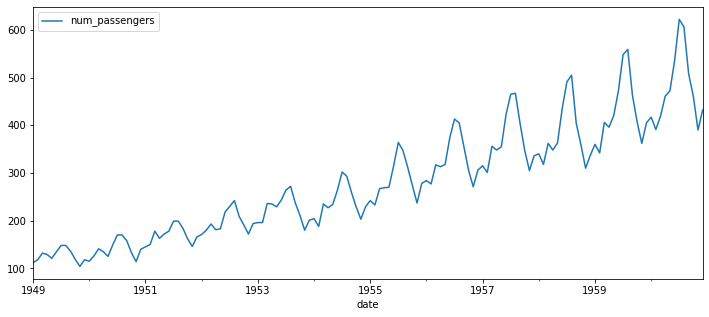

In [56]:
passengers.plot(figsize=(12,5))
plt.show()

Как было отмечено ранее, представленный временной ряд не является стационарным. В нем наблюдаются как тренд, так и сезонность. Кроме того, дисперсия на разных участках ряда не постоянна. Поэтому сначала выполним преобразование Бокса-Кокса.

## 1. Автокорреляция и частичная автокорреляция

Согласно теореме Вольда стационарный ряд можно описать моделью ARMA. Возникает вопрос: как определить порядок авторегрессии и порядок скользящего среднего? Для начала исходный ряд приводят к стационарному. После чего для определения порядка скользящего среднего прибегают к анализу коррелограммы полученного ряда.

In [57]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [58]:
passengers_transformed, lmbda = boxcox(passengers['num_passengers'])
y_transformation = pd.DataFrame(passengers['num_passengers'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [59]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.991880
После преобразования Бокса-Кокса: p=0.617162
После сезонного дифференцирования: p=0.052505
После дополнительного дифференцирования: p=0.000304


Рассмотрим коррелограмму полученного ряда.

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

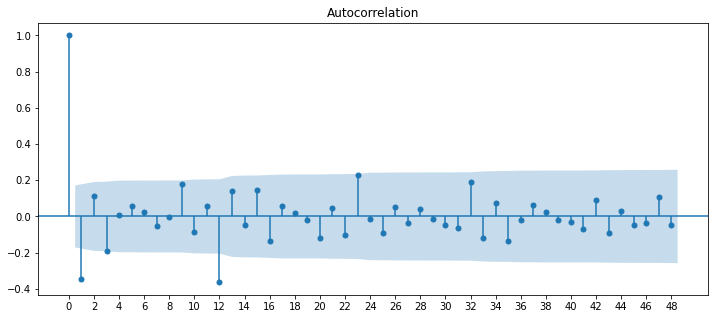

In [61]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

В качестве начального приближения гиперпараметра $q$ берется последний значимый лаг автокорреляции. Для примера выше последний значимый лаг равен 1. При лаге равном 2 значение автокорреляции попадает внутрь голубого "коридора", поэтому дальнейшие значения автокорреляции не рассматриваются, $q_0=1$.

Аналогичным образом определяется начальное приближение для сезонного порядка скользящего среднего $Q$. Необходимо определить последний значимый сезонный лаг автокорреляции. На графике выше последним значимым лагом является 12 (один сезонный период). Соответственно, порядок $Q_0=1$.

**Замечание по терминологии**: гиперпараметрами модели называют те параметры, которые задаются пользователем. Параметрами же называют подобранные путем минимизации функционала качества моделью коэффициенты. Функционалом качества может выступать, например, среднеквадратичная ошибка.

Т.е. когда речь идет о модели $ARIMA(p,d,q)$, гиперпараметрами являются $p$, $d$ и $q$, которые задаются вручную. Параметрами при этом являются коэффициенты $\alpha$, $\phi$ и $\theta$.

Для выбора начального приближения порядка авторегрессии $p$ прибегают к аналогичному методу, но рассматривают частичную автокорреляцию. Частичная автокорреляция &ndash; это автокорреляция после снятия авторегрессии предыдущего порядка. Для определения значения частичной автокорреляции с лагом 2 необходимо построить авторегрессию порядка 1 ($AR(1)$), вычесть эту авторегрессию из ряда и вычислить автокорреляцию на полученных остатках, т.е.:
$$\phi_{hh}=\begin{cases} r(y_{t+1},y_t), & h=1, \\ 
r(y_{t+h}-y_{t+h}^{h-1},y_t-y_t^{h-1}), & h\ge1, \end{cases}$$
где $y_t^{h-1} -$ авторегрессии следующего вида:
$$y_t^{h-1}=\beta_1 y_{t+1}+\beta_2 y_{t+2}+...+\beta_{h-1} y_{t+h-1},$$
$$y_{t+h}^{h-1}=\beta_1 y_{t+h-1}+\beta_2 y_{t+h-2}+...+\beta_{h-1} y_{t+1}.$$

Для построения графика частичной автокорреляции служит функция `plot_pacf`, которая находится в том же модуле `statsmodels.graphics.tsaplots`.

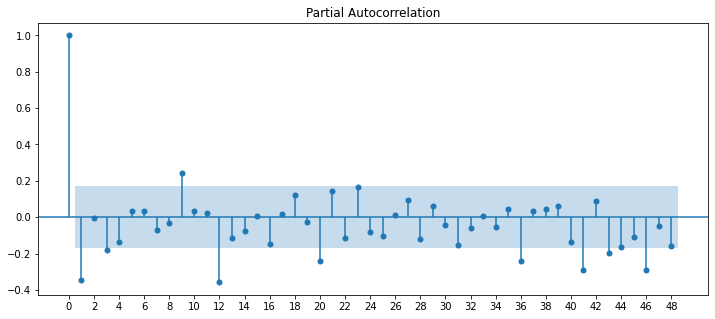

In [62]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг также равен 1, соответственно, $p_0=1$. При лаге 24 автокорреляцию можно считать значимой, однако слишком высокий порядок авторегрессии выбирать не рекомендуется. Возьмем $P_0=1$.

Для выбора оптимальных значений гиперпараметров $p$, $q$, $P$ и $Q$ необходимо построить соответствующие модели авторегрессии и оценить их качество. Поскольку вариантов достаточно много, обычно рассматриваются гиперпараметры в окрестности начального приближения  $p_0$, $q_0$, $P_0$, $Q_0$.

In [63]:
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [64]:
from itertools import product

In [65]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

36

Получили 36 возможных наборов гиперпараметров. Гиперпараметры модели нельзя выбирать методом максимального правдоподобия, поскольку с увеличением количества параметров значение функции правдоподобия $L$ растет. 

Поэтому для сравнения различных моделей применяется информационный критерий Акаике:
$$AIC=-2L+2k,$$
где $k$ &ndash; число параметров модели. Чем меньше значение данного критерия, тем лучше.

## 2. Построение модели SARIMA

Модель SARIMA можно найти в модуле `statsmodels.tsa.statespace.sarimax`. Процесс обучения модели (настройки параметров модели) аналогичен процессу обучения адаптивных методов.

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Обучим модель `SARIMA(1,1,0),(1,1,1)`. В качестве первого аргумента функции `SARIMAX` необходимо передать временной ряд. Чтобы определить порядки авторегрессии, дифференцирования и скользящего среднего необходимо передать их в виде кортежа в аргумент `order`. В данном случае передадим временной ряд, полученный после сезонного дифференцирования, поскольку обычное дифференцирование функция произведет самостоятельно.

In [67]:
model = SARIMAX(y_transformation['initial'], 
                order=(1, 1, 0), 
                seasonal_order=(1, 1, 1, 12)).fit()

Значение критерия Акаике:

In [68]:
model.aic

1020.4927998850501

Прогноз модели также можно получить с помощью функций `forecast` и `predict`.

In [69]:
model.params

ar.L1        -0.322589
ar.S.L12     -0.890945
ma.S.L12      0.791264
sigma2      131.525054
dtype: float64

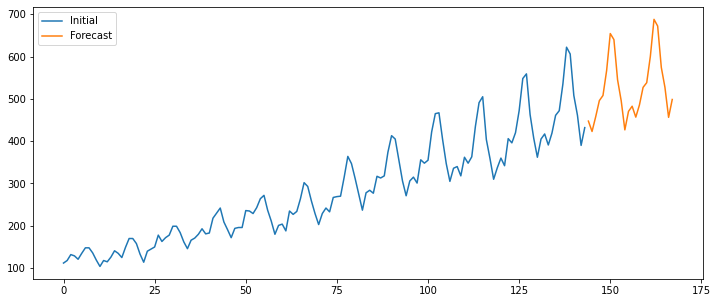

In [70]:
y_transformation['initial'].plot(figsize=(12,5))
model.forecast(24).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
<ol>
<li>Среди ранее полученных наборов гиперпараметров (<b>parameters_list</b>) найдите тот, для которого критерий Акаике минимален.</li>
    <p></p>
<li>С помощью функции <b>predict</b> получите прогноз на 36 точек вперед и отобразите его на графике.</li>
    <p></p>
</ol>
</div>

<p></p>
</div>

In [71]:
minAIC1 = 10000000
opt_par1 = -1

for i in parameters_list:
    model = SARIMAX(y_transformation['initial'], 
                order=(i[0], 1, i[1]), 
                seasonal_order=(i[2], 1, i[3], 12)).fit()
    if minAIC1 > model.aic:
        minAIC1 = model.aic
        opt_par1 = i
    print(i, 'AIC =', model.aic)
    
opt_par1

(0, 0, 0, 0) AIC = 1031.508108169623
(0, 0, 0, 1) AIC = 1030.7522489978808
(0, 0, 1, 0) AIC = 1030.4076712383
(0, 0, 1, 1) AIC = 1032.1276185532229
(0, 1, 0, 0) AIC = 1020.6387877525771
(0, 1, 0, 1) AIC = 1021.0025245228236
(0, 1, 1, 0) AIC = 1020.4249498566078
(0, 1, 1, 1) AIC = 1020.3273495502261
(0, 2, 0, 0) AIC = 1022.6269201268502
(0, 2, 0, 1) AIC = 1023.000944351861
(0, 2, 1, 0) AIC = 1022.4243697005084
(0, 2, 1, 1) AIC = 1022.3247804178616
(1, 0, 0, 0) AIC = 1020.3934392701036
(1, 0, 0, 1) AIC = 1020.9136714618742
(1, 0, 1, 0) AIC = 1020.392948451615
(1, 0, 1, 1) AIC = 1020.4927998850501
(1, 1, 0, 0) AIC = 1022.3932881270329
(1, 1, 0, 1) AIC = 1022.8964493054344
(1, 1, 1, 0) AIC = 1022.3557767682909
(1, 1, 1, 1) AIC = 1022.2987933598946
(1, 2, 0, 0) AIC = 1024.1604279699827
(1, 2, 0, 1) AIC = 1024.7176991627748
(1, 2, 1, 0) AIC = 1024.1909260388968
(1, 2, 1, 1) AIC = 1024.1213748939767
(2, 0, 0, 0) AIC = 1022.3933631110554
(2, 0, 0, 1) AIC = 1022.9045422218229
(2, 0, 1, 0) AIC =

c:\program files\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\program files\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 0, 0) AIC = 1017.8467852256708
(2, 1, 0, 1) AIC = 1018.3594769855715
(2, 1, 1, 0) AIC = 1017.9144602476417
(2, 1, 1, 1) AIC = 1018.2480108685043
(2, 2, 0, 0) AIC = 1019.2902048023064
(2, 2, 0, 1) AIC = 1019.9350892941488
(2, 2, 1, 0) AIC = 1019.5460686982943
(2, 2, 1, 1) AIC = 1020.0476047243149


(2, 1, 0, 0)

In [72]:
start = len(passengers.values)
end = start + 36
start, end

(144, 180)

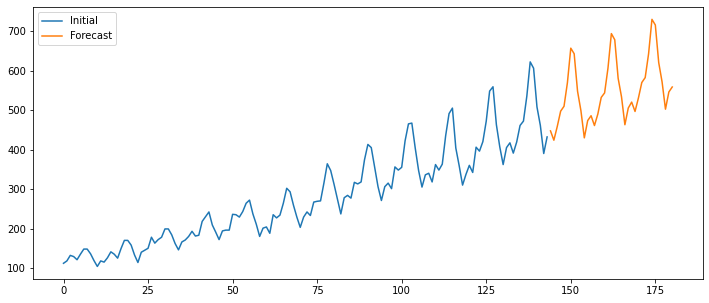

In [73]:
y_transformation['initial'].plot(figsize=(12,5))
model.predict(start=start, end=end).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

Рассмотрим другой пример:

In [74]:
data = pd.read_csv('data/monthly-new-york-city-births.csv', index_col=0, parse_dates=True)

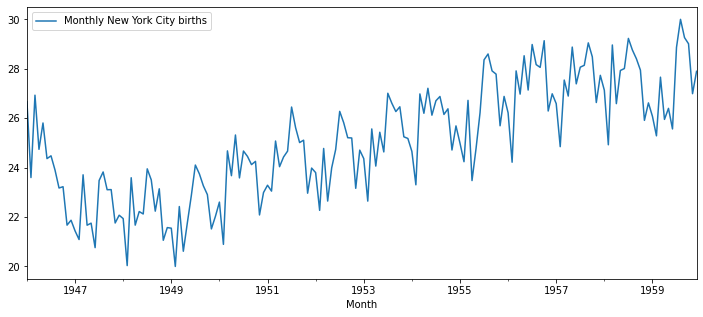

In [75]:
data.plot(figsize=(12,5))
plt.show()

В данном временном ряде присутствуют годовая сезонность и тренд, что можно заметить на коррелограмме:

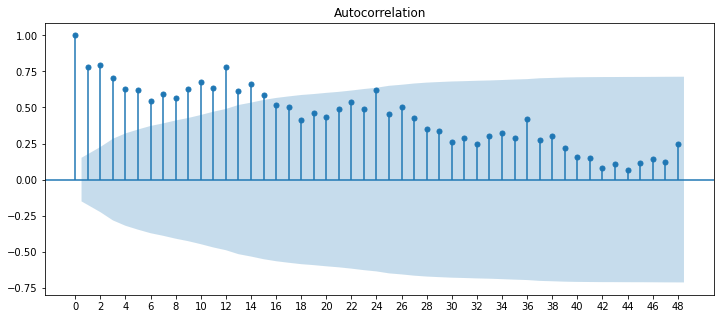

In [76]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(data['Monthly New York City births'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

По автокоррелограмме понятно, что у данных присутствует тренд и затухающая сезонность

Наличие сезонных закономерностей также можно определить, разложив ряд на составляющие с помощью функции `statsmodels.tsa.seasonal.seasonal_decompose`.

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose

В statsmodels применяется следующий алгоритм декомпозиции ряда:

1. Тренд выявляется с помощью скользящего среднего, который затем вычитается из исходного ряда.

2. Сезонность. Полученный ряд группируется по месяцам (если период сезонности &ndash; год, период задается опцией `period`), значения усредняются. Поэтому на графике вы увидите, что максимальные и минимальные значения каждый год совпадают.

3. Остатки. Из исходного ряда вычитаются тренд и сезонность, полученные в 1 и 2. Полученный ряд является рядом остатков.

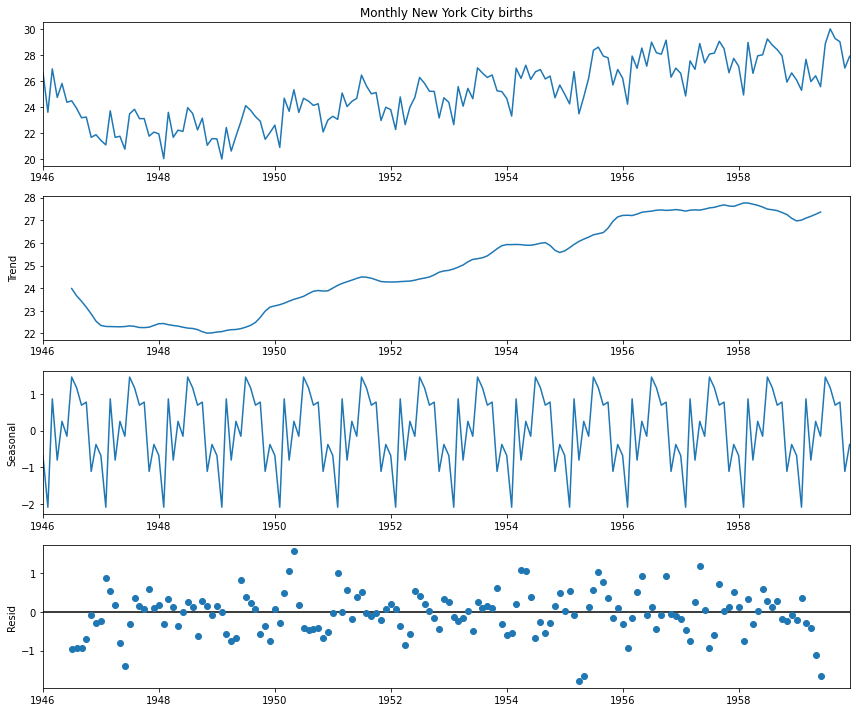

In [78]:
plt.rcParams['figure.figsize'] = (12,10)
seasonal_decompose(data['Monthly New York City births'], period=12).plot()
plt.show()

In [79]:
transformed, lmbda = boxcox(data['Monthly New York City births'])
y_transformation = pd.DataFrame(data['Monthly New York City births'].values, columns=['initial'])
y_transformation['transformed'] = transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [80]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.920956
После преобразования Бокса-Кокса: p=0.920569
После сезонного дифференцирования: p=0.012798
После дополнительного дифференцирования: p=0.000152


Критерий Дики-Фуллера говорит о том, что после сезонного и обычного дифференцирований ряд является стационарным.

<div class="alert alert-info">

<h3> Задание 2</h3>
<p></p>
<ol>
<li>По автокорреляции и частичной автокорреляции определите начальное приближение для порядков авторегресии и скользящего среднего.</li>
    <p></p>
<li>Постройте модель SARIMA с различными наборами гиперпараметров $p, q, P, Q$. Выберите оптимальную модель по критерию Акаике.</li>
    <p></p>
<li>Постройте прогноз на 36 точек вперед.</li>
    <p></p>
</ol>
</div>

<p></p>
</div>

q = 0; Q = 1; p = 0; P = 3 - начальное приближение (+ рассмотреть еще 2 ближайших приближения)

In [81]:
myq = [0, 1, 2]
myQ = [0, 1, 2]
myp = [0, 1, 2]
myP = [1, 2, 3]

In [82]:
new_parameters = product(myp, myq, myP, myQ)
new_parameters_list = list(new_parameters)

In [84]:
minAIC2 = 10000000
opt_par2 = -1

for i in new_parameters_list:
    model = SARIMAX(y_transformation['initial'], 
                order=(i[0], 1, i[1]), 
                seasonal_order=(i[2], 1, i[3], 12)).fit()
    if minAIC2 > model.aic:
        minAIC2 = model.aic
        opt_par2 = i
    
opt_par2

c:\program files\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\program files\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\program files\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\program files\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\program files\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: M

(2, 0, 3, 2)

In [85]:
minAIC2

306.1839031246965

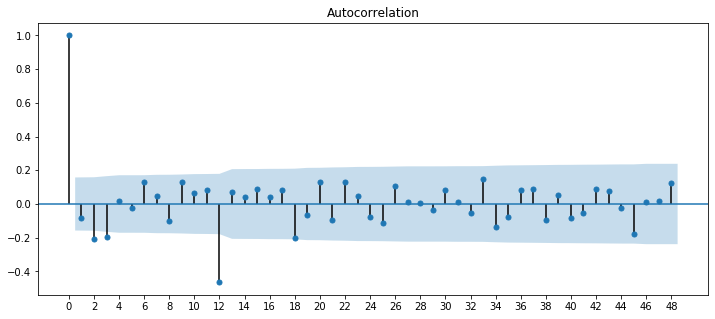

In [25]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

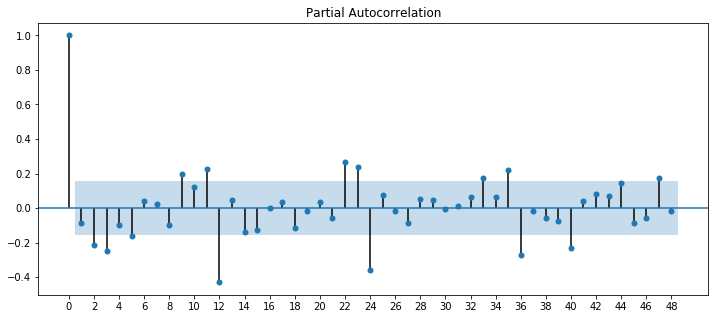

In [26]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()